## 1. Library Imports

In [1]:
# General libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Path handling
from pathlib import Path

# Torch libraries
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#### Check if CUDA (GPU) is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## 2. Dataset Structure and Path Setup

We are using the LC25000 dataset which contains histopathological images categorized into:

- Lung benign tissue
- Lung adenocarcinoma
- Lung squamous cell carcinoma
- Colon adenocarcinoma
- Colon benign tissue

Each category has 5,000 images (total: 25,000 images).


In [2]:
# Set root path
BASE_PATH = Path("lung_colon_image_set")
colon_path = BASE_PATH / "colon_image_sets"
lung_path = BASE_PATH / "lung_image_sets"

# Dictionary of class folders with corresponding (tissue_type, tumor_type)
CLASS_MAP = {
    colon_path / "colon_aca":    ("colon", "adenocarcinoma"),
    colon_path / "colon_n":      ("colon", "benign"),
    lung_path / "lung_aca":      ("lung", "adenocarcinoma"),
    lung_path / "lung_n":        ("lung", "benign"),
    lung_path / "lung_scc":      ("lung", "squamous"),
}

#### Data Summary and Exploration


In [3]:
# Collect metadata
image_paths = []
tissue_labels = []
tumor_labels = []

for folder, (tissue, tumor) in CLASS_MAP.items():
    files = list(folder.glob("*.jpeg"))
    for f in files:
        image_paths.append(str(f))
        tissue_labels.append(tissue)
        tumor_labels.append(tumor)

# Create a DataFrame
df = pd.DataFrame({
    "image_path": image_paths,
    "tissue_type": tissue_labels,
    "tumor_type": tumor_labels
})

df.head()

,image_path,tissue_type,tumor_type
0,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
1,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
2,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
3,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
4,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma


#### Class Distribution

C:\Users\burakdogan\AppData\Local\Temp\ipykernel_20524\423332531.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="tissue_type", palette="Set2")


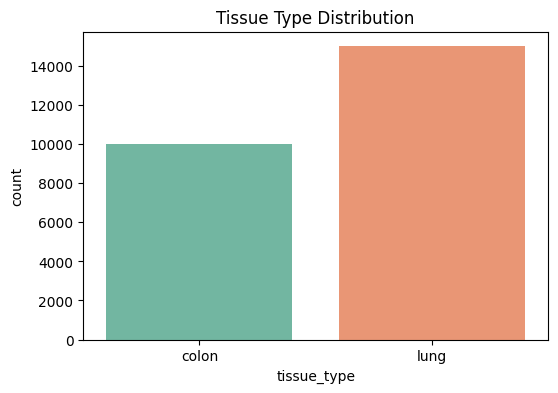

C:\Users\burakdogan\AppData\Local\Temp\ipykernel_20524\423332531.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="tumor_type", palette="Set3")


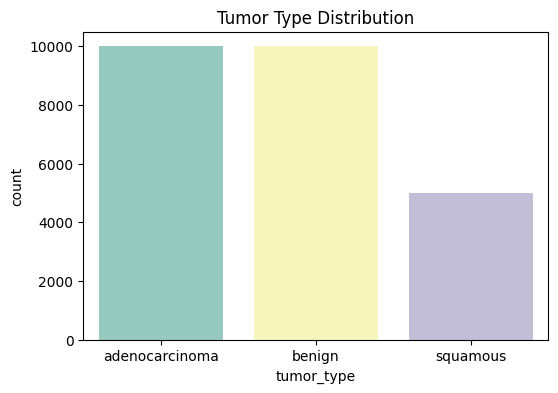

In [4]:
# Tissue class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="tissue_type", palette="Set2")
plt.title("Tissue Type Distribution")
plt.show()

# Tumor type distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="tumor_type", palette="Set3")
plt.title("Tumor Type Distribution")
plt.show()


#### Visualizing Random Samples from Each Class

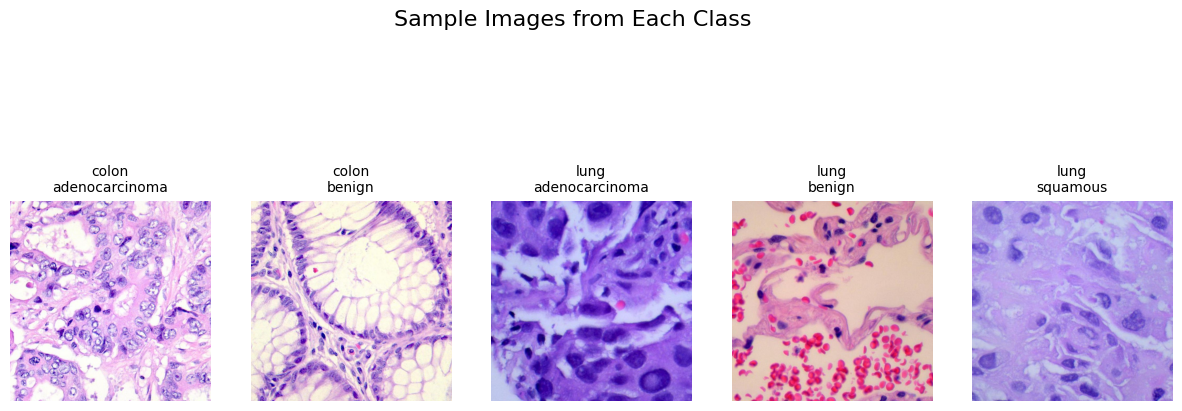

In [5]:
plt.figure(figsize=(15, 6))
for idx, (folder, (tissue, tumor)) in enumerate(CLASS_MAP.items()):
    sample_path = random.choice(list((folder).glob("*.jpeg")))
    img = Image.open(sample_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"{tissue}\n{tumor}", fontsize=10)
    plt.axis("off")
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()

## 3. Data Preprocessing & Transformations

The original image size is 768x768 pixels, which is large and computationally expensive to process. We will resize images to a more manageable size (e.g., 224x224), which is also compatible with common pretrained models like ResNet.

We'll also normalize the images using the ImageNet mean and standard deviation values:
- Mean = [0.485, 0.456, 0.406]
- Std  = [0.229, 0.224, 0.225]


#### Define Transformations

In [6]:
# Image transformations for training and testing
image_size = 224  # Resize all images to 224x224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

## 4. Custom PyTorch Dataset for Multi-task Learning

#### Define Label Mappings

We are doing multi-task learning, so we need to encode:
- Tissue type (`lung`, `colon`) → 0 or 1
- Tumor type (`benign`, `adenocarcinoma`, `squamous`) → 0, 1, 2

These will be our two classification targets.

In [7]:
# Encoding maps
TISSUE_LABELS = {'lung': 0, 'colon': 1}
TUMOR_LABELS = {'benign': 0, 'adenocarcinoma': 1, 'squamous': 2}


#### Define Custom Dataset Class

In [8]:
class HistopathologyMultiTaskDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        tissue_type = TISSUE_LABELS[row['tissue_type']]
        tumor_type = TUMOR_LABELS[row['tumor_type']]
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Return image and both labels as a dictionary
        labels = {
            'tissue': torch.tensor(tissue_type, dtype=torch.long),
            'tumor': torch.tensor(tumor_type, dtype=torch.long)
        }
        return image, labels


#### Sanity Check with Sample

In [9]:
# Sample usage with transformations
dataset = HistopathologyMultiTaskDataset(df, transform=train_transform)

# Check shape and label
sample_img, sample_labels = dataset[0]

print(f"Image shape: {sample_img.shape}")
print(f"Tissue label: {sample_labels['tissue']}")
print(f"Tumor label: {sample_labels['tumor']}")


Image shape: torch.Size([3, 224, 224])
Tissue label: 1
Tumor label: 1


## 5. Dataset Split (Train / Validation / Test) & PyTorch DataLoaders

#### Stratified Train / Validation / Test Split

We will split the dataset as follows:
- 80% → Training
- 10% → Validation
- 10% → Test

We'll stratify by `tumor_type` to maintain class distribution in all subsets.

In [10]:

# First, split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['tumor_type'],
    random_state=42
)

# Then split temp into validation (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['tumor_type'],
    random_state=42
)

# Sanity checks
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Train samples: 20000
Validation samples: 2500
Test samples: 2500


#### Create Dataset Objects

In [11]:
# Create Dataset objects with appropriate transforms
train_dataset = HistopathologyMultiTaskDataset(train_df, transform=train_transform)
val_dataset   = HistopathologyMultiTaskDataset(val_df, transform=test_transform)
test_dataset  = HistopathologyMultiTaskDataset(test_df, transform=test_transform)

#### Create DataLoaders

In [ ]:
# Set batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


#### Sample Batch Preview

In [ ]:
images, labels = next(iter(train_loader))

print(f"Batch image shape: {images.shape}")
print(f"Tissue labels: {labels['tissue'][:5]}")
print(f"Tumor labels: {labels['tumor'][:5]}")

## 6. Model Architecture (Multi-task Learning)

#### Define the Multi-task Model

In multi-task learning, the model has a shared backbone for feature extraction and multiple heads for different tasks. Here, we have:
- **Shared CNN backbone**: Using **ResNet50** pretrained on ImageNet.
- **Two heads**: 
    - One for tissue classification (`lung`, `colon`).
    - One for tumor classification (`benign`, `adenocarcinoma`, `squamous`).

In [ ]:
class MultiTaskResNet50(nn.Module):
    def __init__(self, num_tissue_classes=2, num_tumor_classes=3):
        super(MultiTaskResNet50, self).__init__()
        
        # Load a pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)
        
        # Modify the fully connected layer for the shared backbone
        self.resnet.fc = nn.Identity()  # Remove original fc layer
        
        # Add task-specific heads
        self.tissue_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_tissue_classes)
        )
        
        self.tumor_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_tumor_classes)
        )
    
    def forward(self, x):
        # Extract features from the shared CNN backbone
        features = self.resnet(x)
        
        # Get tissue and tumor predictions from their respective heads
        tissue_output = self.tissue_head(features)
        tumor_output = self.tumor_head(features)
        
        return tissue_output, tumor_output


#### Model Summary

The model uses **ResNet50** as the shared feature extractor, and adds two heads for the respective classification tasks:
1. **Tissue Classification**: Determines if the image is lung or colon tissue.
2. **Tumor Classification**: Determines the type of tumor (benign, adenocarcinoma, squamous).

Here’s a breakdown of the architecture:
- ResNet50 (Pretrained) backbone: Feature extraction layer.
- Tissue head: Fully connected layers for tissue classification.
- Tumor head: Fully connected layers for tumor classification.

#### Check Model Architecture

In [ ]:
# Initialize the model
model = MultiTaskResNet50()

# Print the model architecture
print(model)

## 7. Loss Functions and Optimizer

#### Define Loss Functions

We will use **Cross-Entropy Loss** for both tasks:
- **Tissue Classification**: Using `nn.CrossEntropyLoss()`
- **Tumor Classification**: Using `nn.CrossEntropyLoss()`

Both will be optimized jointly, allowing the model to learn to predict both tissue type and tumor type.


In [ ]:
# Define loss functions for both tasks
tissue_criterion = nn.CrossEntropyLoss()
tumor_criterion = nn.CrossEntropyLoss()


#### Set Up the Optimizer

We will use **Adam** optimizer for training the model. Adam is a good choice for deep learning as it adapts the learning rate during training.
- We will apply a learning rate of **1e-4** to start with.

In [ ]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#### Training and Validation Loss Calculation

During training and validation, we will calculate the losses for both tasks. For each batch:
- Tissue loss = Cross-Entropy loss for tissue classification.
- Tumor loss = Cross-Entropy loss for tumor classification.

The total loss is the sum of these two losses:
- **Total Loss** = Tissue Loss + Tumor Loss


In [ ]:
# Sample loss calculation for one batch
def calculate_loss(tissue_output, tumor_output, tissue_labels, tumor_labels):
    tissue_loss = tissue_criterion(tissue_output, tissue_labels)
    tumor_loss = tumor_criterion(tumor_output, tumor_labels)
    
    total_loss = tissue_loss + tumor_loss
    return total_loss, tissue_loss, tumor_loss


#### Forward Pass Example

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    sample_images, sample_labels = next(iter(train_loader))
    tissue_output, tumor_output = model(sample_images.to(device))

    # Calculate losses for this batch
    total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output,
                                                          sample_labels['tissue'].to(device), 
                                                          sample_labels['tumor'].to(device))

    print(f"Total Loss: {total_loss.item()}, Tissue Loss: {tissue_loss.item()}, Tumor Loss: {tumor_loss.item()}")


## 8. Training Loop

#### Training and Validation Functions

The training function will:
1. Iterate through the training DataLoader.
2. Perform forward and backward passes.
3. Calculate the total loss and the losses for tissue and tumor.
4. Update the model parameters using the optimizer.

The validation function will:
1. Evaluate the model without updating the weights.
2. Calculate the validation loss for both tasks.

Both functions will track the loss for each task during training and validation.

In [ ]:
def train_one_epoch(model, train_loader, optimizer, tissue_criterion, tumor_criterion, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    tissue_loss_total = 0.0
    tumor_loss_total = 0.0
    start_time = time.time()
    
    for batch_idx, sample_batch in enumerate(train_loader):
        images, labels = sample_batch
        images, tissue_labels, tumor_labels = images.to(device), labels['tissue'].to(device), labels['tumor'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        tissue_output, tumor_output = model(images)

        # Calculate losses for both tasks
        total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output, tissue_labels, tumor_labels)

        # Backward pass
        total_loss.backward()

        # Update the weights
        optimizer.step()

        # Track the loss for this batch
        running_loss += total_loss.item()
        tissue_loss_total += tissue_loss.item()
        tumor_loss_total += tumor_loss.item()

        # Print loss stats every 100 batches
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} | Tissue Loss: {tissue_loss.item():.4f} | Tumor Loss: {tumor_loss.item():.4f}")

    epoch_time = time.time() - start_time
    avg_loss = running_loss / len(train_loader)
    avg_tissue_loss = tissue_loss_total / len(train_loader)
    avg_tumor_loss = tumor_loss_total / len(train_loader)

    return avg_loss, avg_tissue_loss, avg_tumor_loss, epoch_time

# Validation function
def validate_one_epoch(model, val_loader, tissue_criterion, tumor_criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    tissue_loss_total = 0.0
    tumor_loss_total = 0.0

    with torch.no_grad():
        for batch_idx, sample_batch in enumerate(val_loader):
            images, labels = sample_batch
            images, tissue_labels, tumor_labels = images.to(device), labels['tissue'].to(device), labels['tumor'].to(device)

            # Forward pass
            tissue_output, tumor_output = model(images)

            # Calculate losses
            total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output, tissue_labels, tumor_labels)

            # Track loss for validation
            running_loss += total_loss.item()
            tissue_loss_total += tissue_loss.item()
            tumor_loss_total += tumor_loss.item()

    avg_loss = running_loss / len(val_loader)
    avg_tissue_loss = tissue_loss_total / len(val_loader)
    avg_tumor_loss = tumor_loss_total / len(val_loader)

    return avg_loss, avg_tissue_loss, avg_tumor_loss


#### Training and Validation Loop

In the loop:
1. Train the model for one epoch.
2. Validate the model after every epoch.
3. Track both training and validation losses.
4. Optionally, save the best model based on validation loss.


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, tissue_criterion, tumor_criterion, device, num_epochs=10):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_tissue_accuracies, val_tissue_accuracies = [], []
    train_tumor_accuracies, val_tumor_accuracies = [], []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        train_loss, train_tissue_loss, train_tumor_loss, train_time = train_one_epoch(
            model, train_loader, optimizer, tissue_criterion, tumor_criterion, device
        )

        # Validate after each epoch
        val_loss, val_tissue_loss, val_tumor_loss = validate_one_epoch(
            model, val_loader, tissue_criterion, tumor_criterion, device
        )

        # Calculate accuracies
        train_tissue_accuracy = accuracy_score(tissue_labels, tissue_preds)
        val_tissue_accuracy = accuracy_score(val_tissue_labels, val_tissue_preds)
        train_tumor_accuracy = accuracy_score(tumor_labels, tumor_preds)
        val_tumor_accuracy = accuracy_score(val_tumor_labels, val_tumor_preds)

        print(f"\nEpoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f} | Train Tissue Loss: {train_tissue_loss:.4f} | Train Tumor Loss: {train_tumor_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Tissue Loss: {val_tissue_loss:.4f} | Val Tumor Loss: {val_tumor_loss:.4f} | "
              f"Time: {train_time:.2f}s")

        # Save the model with the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model based on validation loss.")

        # Track loss and accuracy for visualization
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_tissue_accuracies.append(train_tissue_accuracy)
        val_tissue_accuracies.append(val_tissue_accuracy)
        train_tumor_accuracies.append(train_tumor_accuracy)
        val_tumor_accuracies.append(val_tumor_accuracy)

#### Training the Model

In [ ]:
# Move the model to the selected device (GPU/CPU)
model.to(device)

# Start training
train_model(model, train_loader, val_loader, optimizer, tissue_criterion, tumor_criterion, device, num_epochs=10)

#### 9. Model Testing

#### Define the Test Function

We will evaluate the model using:
- **Accuracy** for tissue classification (lung vs. colon).
- **Accuracy** for tumor classification (benign, adenocarcinoma, squamous).


In [ ]:
def test_model_with_visualization(model, test_loader, device):
    model.eval()
    tissue_preds, tumor_preds = [], []
    tissue_labels, tumor_labels = [], []

    with torch.no_grad():
        for batch_idx, sample_batch in enumerate(test_loader):
            images, labels = sample_batch
            images, tissue_label, tumor_label = images.to(device), labels['tissue'].to(device), labels['tumor'].to(device)

            tissue_output, tumor_output = model(images)
            tissue_preds.extend(torch.argmax(tissue_output, dim=1).cpu().numpy())
            tumor_preds.extend(torch.argmax(tumor_output, dim=1).cpu().numpy())

            tissue_labels.extend(tissue_label.cpu().numpy())
            tumor_labels.extend(tumor_label.cpu().numpy())

    # Accuracy
    tissue_accuracy = accuracy_score(tissue_labels, tissue_preds)
    tumor_accuracy = accuracy_score(tumor_labels, tumor_preds)

    print(f"Test Tissue Classification Accuracy: {tissue_accuracy:.4f}")
    print(f"Test Tumor Classification Accuracy: {tumor_accuracy:.4f}")

    # Classification reports
    tissue_report = classification_report(tissue_labels, tissue_preds, target_names=['lung', 'colon'], output_dict=True)
    tumor_report = classification_report(tumor_labels, tumor_preds, target_names=['benign', 'adenocarcinoma', 'squamous'], output_dict=True)

    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(confusion_matrix(tissue_labels, tissue_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title("Tissue Classification Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_xticklabels(['lung', 'colon'])
    axes[0].set_yticklabels(['lung', 'colon'])

    sns.heatmap(confusion_matrix(tumor_labels, tumor_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title("Tumor Classification Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_xticklabels(['benign', 'adenocarcinoma', 'squamous'], rotation=45)
    axes[1].set_yticklabels(['benign', 'adenocarcinoma', 'squamous'], rotation=45)

    plt.tight_layout()
    plt.show()

    # Barplot: precision, recall, f1-score
    def plot_metrics(report, title):
        metrics = ['precision', 'recall', 'f1-score']
        classes = list(report.keys())[:-3]  # skip avg/total

        data = {metric: [report[cls][metric] for cls in classes] for metric in metrics}
        x = np.arange(len(classes))
        width = 0.2

        fig, ax = plt.subplots(figsize=(10, 6))
        for idx, metric in enumerate(metrics):
            ax.bar(x + idx*width, data[metric], width=width, label=metric)

        ax.set_xticks(x + width)
        ax.set_xticklabels(classes)
        ax.set_ylim(0, 1.05)
        ax.set_title(f'{title} Metrics')
        ax.legend()
        plt.show()

    plot_metrics(tissue_report, "Tissue Classification")
    plot_metrics(tumor_report, "Tumor Classification")

    # Print classification reports
    print("Tissue Classification Report:\n", classification_report(tissue_labels, tissue_preds, target_names=['lung', 'colon']))
    print("Tumor Classification Report:\n", classification_report(tumor_labels, tumor_preds, target_names=['benign', 'adenocarcinoma', 'squamous']))

    return tissue_accuracy, tumor_accuracy


#### Test the Model

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

tissue_accuracy, tumor_accuracy = test_model_with_visualization(model, test_loader, device)


#### Plotting function for overfitting detection and visualization

In [ ]:

def plot_metrics(train_losses, val_losses, train_tissue_accuracies, val_tissue_accuracies, train_tumor_accuracies, val_tumor_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_tissue_accuracies, label='Train Tissue Accuracy', color='blue')
    plt.plot(epochs, val_tissue_accuracies, label='Validation Tissue Accuracy', color='red')
    plt.plot(epochs, train_tumor_accuracies, label='Train Tumor Accuracy', color='green')
    plt.plot(epochs, val_tumor_accuracies, label='Validation Tumor Accuracy', color='orange')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_metrics(train_losses, val_losses, train_tissue_accuracies, val_tissue_accuracies, train_tumor_accuracies, val_tumor_accuracies)